In [1]:
import numpy as np
from numpy import sqrt, pi
import matplotlib.pyplot as plt

from numpy import cos, sin

from matplotlib.colors import Normalize
from matplotlib import cm

# Define spatial grid

In [2]:
rho_min, rho_max, min_delta_rho = 0.0, 5.0, 0.05
z_min, z_max, min_delta_z = -3.0, 6.0, 0.1

In [3]:
assert (rho_min >= 0) and (rho_min < rho_max)
assert (z_min < z_max)

def get_N_grid(xmin, xmax, min_delta_x): 
    return int((xmax-xmin+min_delta_x)/min_delta_x) + 1

N_rho = get_N_grid(rho_min, rho_max, min_delta_rho)
rho_arr = np.linspace(rho_min, rho_max, N_rho)
delta_rho = rho_arr[1] - rho_arr[0]

N_z = get_N_grid(z_min, z_max, min_delta_z)
z_arr = np.linspace(z_min, z_max, N_z)
delta_z = z_arr[1] - z_arr[0]

drho, dz = delta_rho, delta_z  # aliasing

grid_shape = (N_rho, N_z)

## Define 2D meshgrid

In [4]:
Rho, Z = np.meshgrid(rho_arr, z_arr, indexing='ij')

# Construct a boundary condition array

## Define a conductor

In [5]:
z_cy_mid_ind = z_arr.size // 3
z_cy_mid = z_arr[z_cy_mid_ind]

half_l_in_pt_num = z_arr.size // 6
z_cy_max_ind = z_cy_mid_ind + half_l_in_pt_num
z_cy_min_ind = z_cy_mid_ind - half_l_in_pt_num
z_cy_max = z_arr[z_cy_max_ind]
z_cy_min = z_arr[z_cy_min_ind]
# half_l = (half_l_in_ind - 1) * delta_z
l = z_cy_max - z_cy_min

R_ind = rho_arr.size // 3
R = rho_arr[R_ind]

V0 = 1.0
assert z_min < z_cy_mid - l/2 and z_cy_mid + l/2 < z_max

In [6]:
assert rho_min == 0  # so that it can be a cylinder
s1_ind = [(rho_ind, z_cy_max_ind) for rho_ind in range(R_ind+1)]
s2_ind = [(R_ind, z_ind) for z_ind in range(z_cy_min_ind,z_cy_max_ind+1)]
s3_ind = [(rho_ind, z_cy_min_ind) for rho_ind in range(R_ind+1)]

surf_points_ind = np.array([*s1_ind, *s2_ind, *s3_ind])

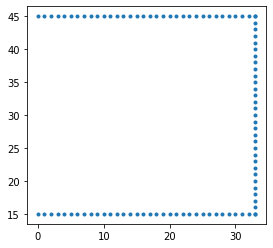

In [7]:
figsu, axsu = plt.subplots()
axsu.plot(surf_points_ind[:,0], surf_points_ind[:,1],'.')
axsu.set_aspect(1.0)

# figsu.savefig("surface-points-cylinder-test-0.png")

# [assumption] each conductors should be separated a bit - in order to prevent some numerical artifacts due to possible discontinuity

In [8]:
bd_cond = np.ma.array(np.full(grid_shape, -1e10, dtype=float), mask=True)

# Bounding box
bd_cond.mask[:,[0,-1]] = False
bd_cond[:,[0,-1]] = 0.0

bd_cond.mask[-1,:] = False
bd_cond[-1,:] = 0.0

if rho_arr[0] > 0: 
    bd_cond.mask[0,:] = False
    bd_cond[0,:] = 0.0
             
# a cylinder
cy_mask = (Rho <= R) & ((z_cy_min) <= Z) & (Z <= (z_cy_max))
bd_cond.mask[cy_mask] = False
bd_cond[cy_mask] = V0

In [9]:
V = np.empty(bd_cond.shape, dtype=float)
V[:] = np.random.rand(*bd_cond.shape)
V[~bd_cond.mask] = bd_cond[~bd_cond.mask]

# Get normal E (.. well, there would only left normal component though) and eval charge dist.

# Auto stop by checking convergence

In [10]:
c1 = 1.0 / (4.0 / drho**2 + 2.0 / dz**2)
c2 = 1.0 / (2.0/drho**2 + 2.0/dz**2)


for _ in range(1000):
    
    V[0,1:-1] = c1 * (
        4.0 / drho**2 * V[1,1:-1]
        + 1.0 / dz**2 * (V[0,2:] + V[0,:-2])
    )

    V[1:-1,1:-1] = c2 * (
        1.0/drho**2 * (V[2:,1:-1] + V[:-2,1:-1]) 
        + (1.0/2.0/drho /rho_arr[1:-1] * (V[2:,1:-1] - V[:-2,1:-1]).transpose()).transpose()
        + 1.0/dz**2 * (V[1:-1,2:] + V[1:-1,:-2])
    )
    
    V[~bd_cond.mask] = bd_cond[~bd_cond.mask]

# Eval normal E

In [11]:
epsil0 = 1.0 / (4*pi)
s1_sigma = np.array([epsil0 * -(V[rho_ind, z_ind+1] - V[rho_ind,z_ind]) / delta_z for (rho_ind, z_ind) in s1_ind])
s2_sigma = np.array([epsil0 * -(V[rho_ind+1, z_ind] - V[rho_ind,z_ind]) / delta_rho for (rho_ind, z_ind) in s2_ind])
s3_sigma = np.array([epsil0 * (V[rho_ind, z_ind] - V[rho_ind,z_ind-1]) / delta_z for (rho_ind, z_ind) in s3_ind])

In [12]:
s1_rho_arr = rho_arr[np.array(s1_ind)[:,0]]
s1_rho_grid = np.empty((len(s1_ind)+1,))
s1_rho_grid[0] = s1_rho_arr[0] - 0.5*delta_rho
s1_rho_grid[-1] = s1_rho_arr[-1] + 0.5*delta_rho
s1_rho_grid[1:-1] = 0.5 * (s1_rho_arr[:-1] + s1_rho_arr[1:])

s1_z_arr = z_arr[np.array(s1_ind)[0,0]].reshape(1,)
s1_z_grid = np.array((z_cy_max-0.5*delta_z,z_cy_max+0.5*delta_z))
# construct_catesian_mesh_for_pcolormesh(s1_rho_arr, s1_z_arr)

s1_Rho, s1_Z = np.meshgrid(s1_rho_grid, s1_z_grid, indexing='ij')

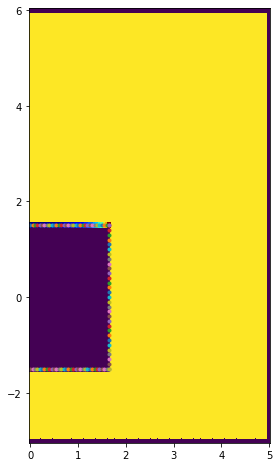

In [13]:
from vis.plot import construct_catesian_mesh_for_pcolormesh
Rho_mesh, Z_mesh = construct_catesian_mesh_for_pcolormesh(rho_arr, z_arr)

figg ,axx = plt.subplots(figsize=(6,8))
axx.pcolormesh(Rho_mesh, Z_mesh, bd_cond.mask)
axx.set_aspect(1.0)

for (rho_ind, z_ind) in surf_points_ind:
    rho, z = rho_arr[rho_ind], z_arr[z_ind]
    axx.plot(rho, z, '.')
# axx.plot(surf_points[:,0], surf_points[:,1],'.')
# axx.imshow(bd_cond.mask)

axx.pcolormesh(s1_Rho, s1_Z, s1_sigma.reshape((s1_sigma.size,1)), cmap='jet')

# figg.savefig("mask-with-surf-and-near-points-test-1.png")

In [14]:
phi_arr = np.linspace(0,2*pi,51)

In [15]:
sigma = np.array([*s1_sigma, *s2_sigma, *s3_sigma])
ch_max, ch_min = sigma.max(), sigma.min()

# vmax = max(abs(ch_max), abs(ch_min))
# vmin = -vmax

vmin, vmax = ch_min, ch_max

norm = Normalize(vmin, vmax, clip=True)

# ch_cm = cm.seismic
ch_cm = cm.jet

In [16]:
s1_3d_rho_grid = np.empty((s1_rho_arr.size+1,))
s1_3d_rho_grid[1:-1] = 0.5 * (s1_rho_arr[:-1] + s1_rho_arr[1:])
s1_3d_rho_grid[0] = 0.0
s1_3d_rho_grid[-1] = R

In [17]:
S1_3D_Rho_Grid, S1_3D_Phi_Grid = np.meshgrid(s1_3d_rho_grid, phi_arr)
S1_3D_X = S1_3D_Rho_Grid * cos(S1_3D_Phi_Grid)
S1_3D_Y = S1_3D_Rho_Grid * sin(S1_3D_Phi_Grid)
S1_3D_Z = np.full_like(S1_3D_X, z_cy_max)

# S1_3D_Rho, S1_3D_Phi = np.meshgrid(s1_rho_arr, phi_arr)
# S1_3D_X = S1_3D_Rho * cos(S1_3D_Phi)
# S1_3D_Y = S1_3D_Rho * sin(S1_3D_Phi)
# S1_3D_Z = np.full_like(S1_3D_X, z_cy_max)

S1_Colors = np.empty((phi_arr.size, s1_rho_arr.size))
S1_Colors[:] = s1_sigma

# s1_norm = Normalize(S1_Colors.min(), S1_Colors.max(), clip=True)
S1_C = ch_cm(norm(S1_Colors))

In [18]:
s3_rho_arr = s1_rho_arr
s3_3d_rho_grid = s1_3d_rho_grid
S3_3D_Rho_Grid, S3_3D_Phi_Grid = np.meshgrid(s3_3d_rho_grid, phi_arr)
S3_3D_X = S3_3D_Rho_Grid * cos(S3_3D_Phi_Grid)
S3_3D_Y = S3_3D_Rho_Grid * sin(S3_3D_Phi_Grid)
S3_3D_Z = np.full_like(S3_3D_X, z_cy_min)

S3_Colors = np.empty((phi_arr.size, s3_rho_arr.size))
S3_Colors[:] = s3_sigma

# s3_norm = Normalize(S3_Colors.min(), S3_Colors.max(), clip=True)
S3_C = ch_cm(norm(S3_Colors))

In [19]:
s2_z_arr = z_arr[np.array(s2_ind)[:,1]]

s2_3d_z_grid = np.empty(s2_z_arr.size + 1,)
s2_3d_z_grid[0] = s2_z_arr[0]
s2_3d_z_grid[1:-1] = 0.5 * (s2_z_arr[:-1] + s2_z_arr[1:])
s2_3d_z_grid[-1] = s2_z_arr[-1]

S2_3D_Z_Grid, S2_3D_Phi_Grid = np.meshgrid(s2_3d_z_grid, phi_arr)
S2_3D_X = R * cos(S2_3D_Phi_Grid)
S2_3D_Y = R * sin(S2_3D_Phi_Grid)
S2_3D_Z = S2_3D_Z_Grid

S2_Colors = np.empty((phi_arr.size, s2_z_arr.size))
S2_Colors[:] = s2_sigma

# s2_norm = Normalize(S2_Colors.min(), S2_Colors.max(), clip=True)
S2_C = ch_cm(norm(S2_Colors))

In [20]:
# S2_3D_Z_Grid, S2_3D_Phi_Grid = np.meshgrid(s2_3d_z_grid, phi_arr)
# S3_3D_X = S3_3D_Rho_Grid * cos(S3_3D_Phi_Grid)
# S3_3D_Y = S3_3D_Rho_Grid * sin(S3_3D_Phi_Grid)
# S3_3D_Z = np.full_like(S3_3D_X, z_cy_min)

# S3_Colors = np.empty((phi_arr.size, s3_rho_arr.size))
# S3_Colors[:] = s3_sigma

# s3_norm = Normalize(S3_Colors.min(), S3_Colors.max(), clip=True)
# S3_C = cm.jet(s3_norm(S3_Colors))

(-2, 2)

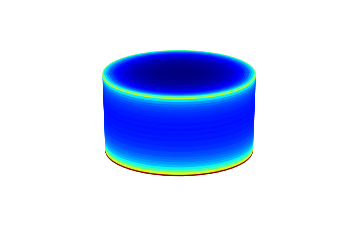

In [21]:
from mpl_toolkits.mplot3d import Axes3D

fig3, ax3 = plt.subplots(subplot_kw={'projection':'3d'})

s2_cc = ax3.plot_surface(S2_3D_X, S2_3D_Y, S2_3D_Z, facecolors=S2_C, cmap=ch_cm)
s1_cc = ax3.plot_surface(S1_3D_X, S1_3D_Y, S1_3D_Z, facecolors=S1_C, cmap=ch_cm)
s3_cc = ax3.plot_surface(S3_3D_X, S3_3D_Y, S3_3D_Z, facecolors=S3_C, cmap=ch_cm)

ax3.view_init(elev=30, azim=None)

ax3.set_axis_off()

ax3.set_xlim(-2,2)
ax3.set_ylim(-2,2)
ax3.set_zlim(-2,2)

# s1_cc.set_clim(S1_Colors.min(), S1_Colors.max())
# s1_cb = fig3.colorbar(s1_cc, ax=ax3)

In [22]:
# fig3.savefig("charge-density-test-5.png")

# Eval and Draw E field line

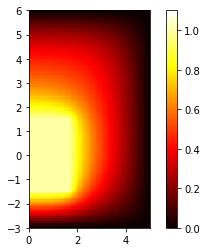

In [23]:
fig, ax = plt.subplots()
img = ax.imshow(V.transpose(), origin='lower', extent=(rho_min,rho_max,z_min,z_max), cmap='hot', vmax=1.1)
cb = fig.colorbar(img, ax=ax)

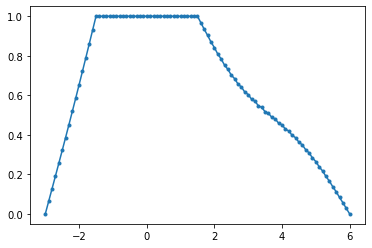

In [24]:
figs, axs = plt.subplots()
axs.plot(z_arr, V[4], '.-')

In [25]:
fig_filename = "single-cylinder-V0={:.3f}-test-0.png".format(V0)
print(fig_filename)
# fig.savefig(fig_filename)

single-cylinder-V0=1.000-test-0.png
